## Problem statement:Calculate the current milk production.
## Approach used:Regression

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression,f_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [44]:
milkdata=pd.read_csv("Milk Production Data.txt",sep='\t')
temp=milkdata.copy(deep=True)

In [45]:
milkdata.isnull().sum()

CurrentMilk    0
Previous       0
Fat            0
Protein        0
Days           0
Lactation      0
I79            0
dtype: int64

#### No null values in the dataset

In [46]:
duplicate = milkdata[milkdata.duplicated()] 
len(duplicate)

0

#### No duplicate records found

In [47]:
milkdata['I79'].value_counts()

1    169
0     30
Name: I79, dtype: int64

In [48]:
 milkdata['Fat'].value_counts()

3.8    16
2.9    14
3.6    12
3.5    12
3.3    11
4.1    11
3.7    11
3.2    10
2.8     8
4.0     7
3.9     7
4.3     7
2.5     7
3.1     6
4.2     6
3.4     6
3.0     5
4.5     4
4.7     4
4.4     4
4.6     4
2.7     3
5.9     3
6.4     2
5.5     2
2.3     2
2.4     2
2.6     2
5.1     1
7.4     1
4.9     1
1.8     1
6.2     1
5.3     1
5.8     1
4.8     1
5.7     1
6.5     1
5.2     1
Name: Fat, dtype: int64

In [49]:
milkdata['Previous'].value_counts()

62    13
57    10
63     8
75     7
60     7
      ..
95     1
96     1
98     1
99     1
17     1
Name: Previous, Length: 68, dtype: int64

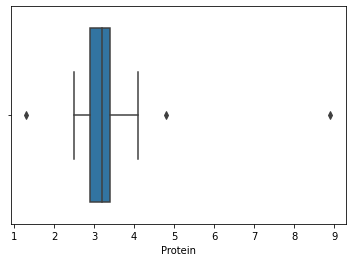

In [50]:
sns.boxplot(x='Protein',data=milkdata)

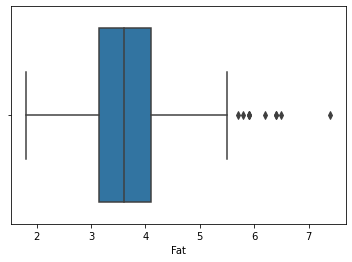

In [51]:
sns.boxplot(x='Fat',data=milkdata)

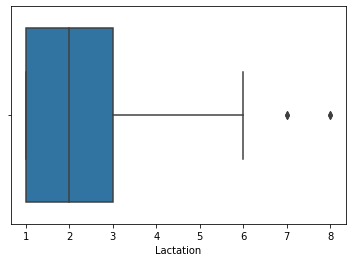

In [52]:
sns.boxplot(x='Lactation',data=milkdata)

In [53]:
milkdata.describe()

,CurrentMilk,Previous,Fat,Protein,Days,Lactation,I79
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,64.819095,62.603015,3.723116,3.184774,155.055276,2.236181,0.849246
std,18.129095,16.790696,0.874884,0.546092,68.280482,1.463184,0.358711
min,14.000000,17.000000,1.800000,1.300000,21.000000,1.000000,0.000000
25%,54.000000,53.000000,3.150000,2.900000,105.000000,1.000000,1.000000
50%,64.000000,62.000000,3.600000,3.200000,149.000000,2.000000,1.000000
75%,77.000000,73.000000,4.100000,3.400000,208.500000,3.000000,1.000000
max,113.000000,104.000000,7.400000,8.900000,301.000000,8.000000,1.000000


In [54]:
milkdata.skew(axis=0)

CurrentMilk   -0.160819
Previous      -0.066733
Fat            1.158438
Protein        5.795885
Days           0.245063
Lactation      1.605884
I79           -1.966997
dtype: float64

#### Protein is very much skewed whereas Lactation and Fat are moderately skewed.Rest of the features are normally distributed.

#### Outliers in Protein,Fat and Lactation features.Our dataset has only 200 entries,removing the outliers would further reduce the   data

In [55]:
milkdata

,CurrentMilk,Previous,Fat,Protein,Days,Lactation,I79
0,45,45,5.5,8.9,21,5,0
1,86,86,4.4,4.1,25,4,0
2,50,50,6.5,4.0,25,7,0
3,42,42,7.4,4.1,25,2,0
4,61,61,3.8,3.8,33,2,0
...,...,...,...,...,...,...,...
194,89,89,3.3,3.0,149,2,1
195,68,69,3.5,3.4,149,2,1
196,55,54,5.9,3.4,149,1,1
197,47,57,3.5,2.9,149,2,1


In [56]:
milkdata1=milkdata.drop('I79',axis=1)
Q1 = milkdata1.quantile(0.25)
Q3 = milkdata1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

CurrentMilk     23.00
Previous        20.00
Fat              0.95
Protein          0.50
Days           103.50
Lactation        2.00
dtype: float64


In [57]:
print(milkdata1['Fat'].quantile(0.10))
print(milkdata1['Fat'].quantile(0.90))

2.8
4.7


In [58]:
milkdata['Fat'] = np.where(milkdata['Fat'] <2.8, 2.8,milkdata['Fat'])
milkdata['Fat']= np.where(milkdata['Fat'] >4.7, 4.7,milkdata['Fat'])
print(milkdata['Fat'].skew())

0.20496147139552073


In [59]:
print(milkdata1['Protein'].quantile(0.10))
print(milkdata1['Protein'].quantile(0.90))

2.8
3.6


In [60]:
milkdata['Protein'] = np.where(milkdata['Protein'] <2.8, 2.8,milkdata['Protein'])
milkdata['Protein']= np.where(milkdata['Protein'] >3.6, 3.6,milkdata['Protein'])
print(milkdata['Protein'].skew())

0.17787701201404774


In [61]:
print(milkdata1['Lactation'].quantile(0.10))
print(milkdata1['Lactation'].quantile(0.90))

1.0
4.0


In [62]:
milkdata['Lactation'] = np.where(milkdata['Lactation'] <1.0, 1.0,milkdata['Lactation'])
milkdata['Lactation']= np.where(milkdata['Lactation'] >4.0, 4.0,milkdata['Lactation'])
print(milkdata['Lactation'].skew())

0.7053081727917514


#### We have removed outliers by capping and flooring.Now the distribution of these variables are near normal.

###### Converting I79 to Categorical variable and later dummy encoding it for better understanding of code

In [63]:
milkdata.describe()

,CurrentMilk,Previous,Fat,Protein,Days,Lactation,I79
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,64.819095,62.603015,3.658291,3.158141,155.055276,2.075377,0.849246
std,18.129095,16.790696,0.613336,0.260091,68.280482,1.077477,0.358711
min,14.000000,17.000000,2.800000,2.800000,21.000000,1.000000,0.000000
25%,54.000000,53.000000,3.150000,2.900000,105.000000,1.000000,1.000000
50%,64.000000,62.000000,3.600000,3.200000,149.000000,2.000000,1.000000
75%,77.000000,73.000000,4.100000,3.400000,208.500000,3.000000,1.000000
max,113.000000,104.000000,4.700000,3.600000,301.000000,4.000000,1.000000


In [64]:
milkdata.skew(axis=0)

CurrentMilk   -0.160819
Previous      -0.066733
Fat            0.204961
Protein        0.177877
Days           0.245063
Lactation      0.705308
I79           -1.966997
dtype: float64

In [65]:
temp.corr().transpose()

,CurrentMilk,Previous,Fat,Protein,Days,Lactation,I79
CurrentMilk,1.000000,0.744579,-0.117107,-0.354983,-0.468121,0.123854,-0.279918
Previous,0.744579,1.000000,-0.161546,-0.306036,-0.317563,0.090382,-0.015018
Fat,-0.117107,-0.161546,1.000000,0.396849,-0.056295,0.096320,-0.072524
Protein,-0.354983,-0.306036,0.396849,1.000000,0.061427,0.192440,-0.098664
Days,-0.468121,-0.317563,-0.056295,0.061427,1.000000,-0.095826,0.615237
Lactation,0.123854,0.090382,0.096320,0.192440,-0.095826,1.000000,-0.220497
I79,-0.279918,-0.015018,-0.072524,-0.098664,0.615237,-0.220497,1.000000


In [66]:
milkdata.corr().transpose()

,CurrentMilk,Previous,Fat,Protein,Days,Lactation,I79
CurrentMilk,1.000000,0.744579,-0.128498,-0.517995,-0.468121,0.117568,-0.279918
Previous,0.744579,1.000000,-0.150164,-0.432314,-0.317563,0.139848,-0.015018
Fat,-0.128498,-0.150164,1.000000,0.393330,0.004095,0.052164,-0.005768
Protein,-0.517995,-0.432314,0.393330,1.000000,0.282882,0.152427,0.047324
Days,-0.468121,-0.317563,0.004095,0.282882,1.000000,-0.076874,0.615237
Lactation,0.117568,0.139848,0.052164,0.152427,-0.076874,1.000000,-0.153392
I79,-0.279918,-0.015018,-0.005768,0.047324,0.615237,-0.153392,1.000000


C:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


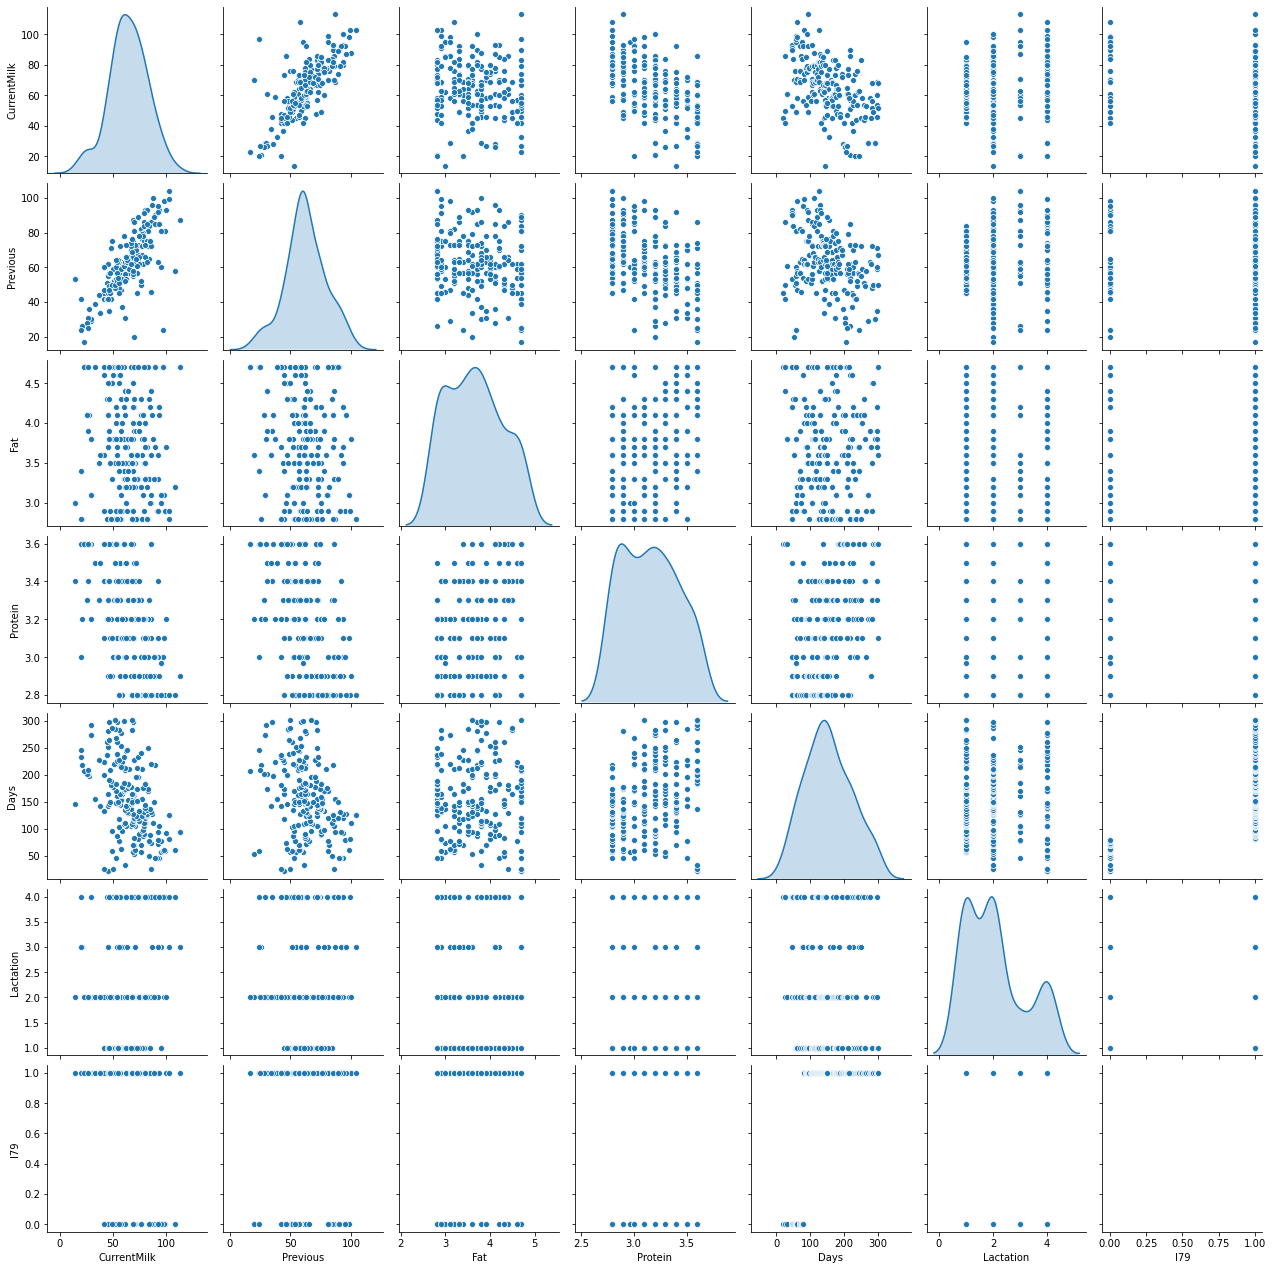

In [25]:
import seaborn as sns
sns.pairplot(milkdata,diag_kind='kde')

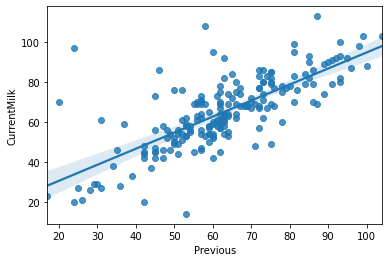

In [67]:
sns.regplot(x = "Previous",  
            y = "CurrentMilk",  
            data = milkdata
            ) 

#### Current milk and Previous milk positively correlated(strong)

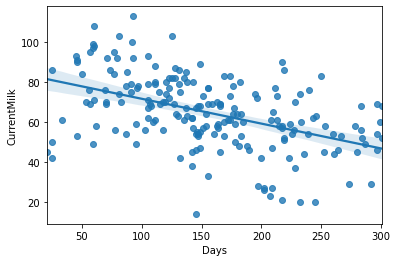

In [68]:
sns.regplot(x = "Days",  
            y = "CurrentMilk",  
            data = milkdata,
            dropna = True) 

#### Current milk and Days negatively correlated(medium)

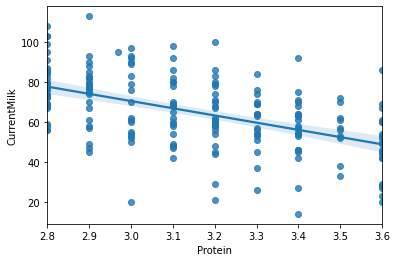

In [69]:
sns.regplot(x = "Protein",  
            y = "CurrentMilk",  
            data = milkdata
            ) 

#### Current milk and Protein negatively correlated(weak)

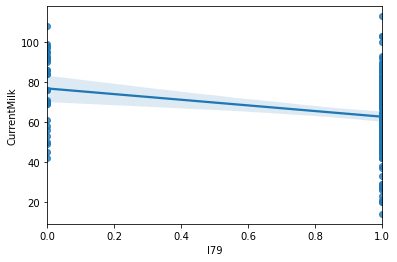

In [70]:
sns.regplot(x = "I79",  
            y = "CurrentMilk",  
            data = milkdata
            ) 

#### Current milk and I79 negatively correlated(weak)

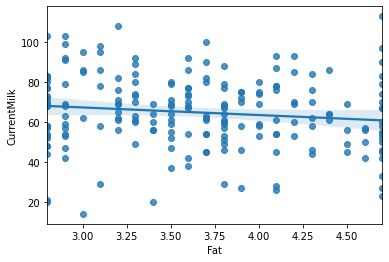

In [71]:
sns.regplot(x = "Fat",  
            y = "CurrentMilk",  
            data = milkdata
            ) 

#### Current milk and Fat negatively correlated(weak)

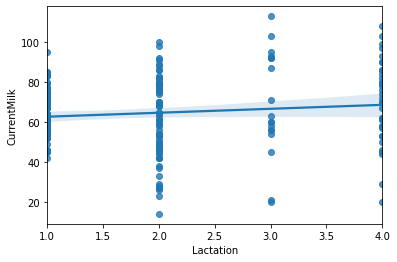

In [72]:
sns.regplot(x = "Lactation",  
            y = "CurrentMilk",  
            data = milkdata
            ) 

#### Current milk and Lactation negatively correlated(weak)

In [73]:
from scipy.stats import spearmanr
coef, p = spearmanr(milkdata['I79'], milkdata['CurrentMilk'])
coef

-0.259586492813368

In [74]:
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Samples are correlated (reject H0) p=0.000


In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [76]:
X = milkdata.iloc[:,1:-1]
calc_vif(X)

,variables,VIF
0,Previous,12.041456
1,Fat,43.937362
2,Protein,69.239948
3,Days,7.201749
4,Lactation,5.052605


### Analysis of Variable Inflation factors shows multicollinearity among features

#### Segregating variables: Independent and Dependent Variables

In [77]:
encodeddata=milkdata

In [78]:
#seperating independent and dependent variables
x = encodeddata.drop(['CurrentMilk'], axis=1)
y = encodeddata['CurrentMilk']
x.shape, y.shape
features=x
features

,Previous,Fat,Protein,Days,Lactation,I79
0,45,4.7,3.6,21,4.0,0
1,86,4.4,3.6,25,4.0,0
2,50,4.7,3.6,25,4.0,0
3,42,4.7,3.6,25,2.0,0
4,61,3.8,3.6,33,2.0,0
...,...,...,...,...,...,...
194,89,3.3,3.0,149,2.0,1
195,69,3.5,3.4,149,2.0,1
196,54,4.7,3.4,149,1.0,1
197,57,3.5,2.9,149,2.0,1


#### Splitting into train and test for validation

In [79]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=42)

In [80]:
train_x

,Previous,Fat,Protein,Days,Lactation,I79
56,51,4.3,3.6,261,4.0,1
5,93,4.2,3.0,45,3.0,0
122,57,3.3,2.8,213,1.0,1
113,47,3.6,3.6,200,2.0,1
93,62,4.1,3.0,172,2.0,1
...,...,...,...,...,...,...
106,60,4.2,3.6,183,2.0,1
14,81,2.9,2.8,59,4.0,0
92,53,4.0,3.3,169,4.0,1
179,64,2.9,3.4,138,2.0,1


In [81]:
# Creating instance of Linear Regresssion
lr = LR()

#### This function is to interpret the coefficients

In [82]:
def plot_coefficients(coeff,col):
# Using matplotlib commands to plot
    plt.figure(figsize=(10,6))
    plt.plot(range(len(coeff)),coeff)
    plt.axhline(0, color='r', linestyle='solid')
    plt.xticks(range(len(col)),col,rotation=50)
    plt.ylabel("coefficients")
    plt.xlabel("features")
    plt.show()


#### Multiple Linear Regression

Mean RMSE of Multiple Linear Regression as baseline model: -9.98353072456201
[12.24146396 -0.12126466 -3.5982653  -1.61480619 -0.54558815 -9.86524101]


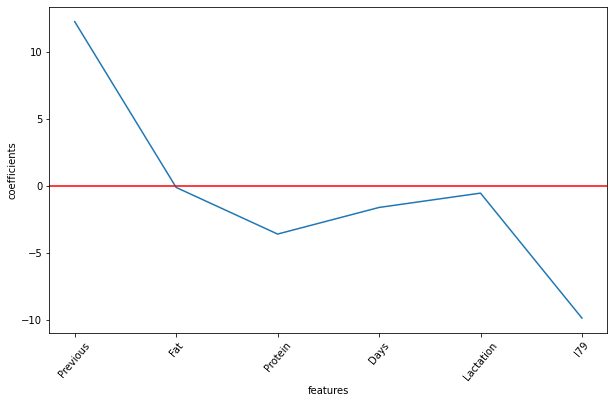

In [85]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
sca_ix = [0,1,2,3,4]
cat_ix = [5]
# define the selective transforms
t = [('e', StandardScaler(), sca_ix)]
selective = ColumnTransformer(transformers=t, remainder='passthrough')
model = LinearRegression()
pipeline = Pipeline(steps=[('sca',selective), ('la', model)])
pipeline.fit(train_x, train_y)
scores = cross_val_score(pipeline, train_x, train_y, scoring='neg_root_mean_squared_error', cv=cv)
print("Mean RMSE of Multiple Linear Regression as baseline model:",scores.mean())
print(pipeline.named_steps['la'].coef_)
plot_coefficients(pipeline.named_steps['la'].coef_,train_x.columns)

### Mean RMSE of baseline model(plain Multiple Linear Regression:9.98

#### Function to tune hyperparameters as well as for feature selection

In [86]:
def tune_algorithm(algo,train_x,train_y,test_x,name):
    
    from sklearn.compose import ColumnTransformer
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    fs = SelectKBest(score_func=mutual_info_regression)
    sca_ix = [0,1,2,3,4]
    cat_ix = [5]
    # define the selective transforms
    t = [('e', StandardScaler(), sca_ix)]
    selective = ColumnTransformer(transformers=t, remainder='passthrough')
    pipeline = Pipeline(steps=[('se',selective),('sel',fs), ('lr', algo)])
    # define the grid
    grid = dict()
    grid['sel__k'] = [i for i in range(1,7)]
    if name=='la':
        grid['lr__alpha'] = [5, 0.5, 0.05, 0.005, 0.0005, 1, 0.1, 0.01,0.001, 0.0001 ]
    elif name=='pls' :
        grid['lr__n_components'] = [1,2,3,4,5,6]
    # define the grid search
    search = GridSearchCV(pipeline, grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)
    # perform the search
    #model = TransformedTargetRegressor(regressor=search, transformer=StandardScaler())
    results = search.fit(train_x, train_y)
    # summarize best
    print('Best RMSE: %.3f' % results.best_score_)
    print('Best Config: %s' % results.best_params_)
    print('Best estimator:',results.best_estimator_)
    means = results.cv_results_['mean_test_score']
    params = results.cv_results_['params']
    for mean, param in zip(means, params):
        print(">%.3f with: %r" % (mean, param))
    test_pred=search.predict(test_x)
    print(results.best_estimator_.named_steps['sel'].get_support())
    print(results.best_estimator_.named_steps['lr'].coef_)
    plot_coefficients(results.best_estimator_.named_steps['lr'].coef_,train_x.columns)
    print(test_pred)

### Feature Selection for Linear Regression+Linear Regression using mutual info regression

Best RMSE: -9.909
Best Config: {'sel__k': 5}
Best estimator: Pipeline(steps=[('se',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('e', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('sel',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_regression at 0x00000222DAEC8280>)),
                ('lr', LinearRegression())])
>-11.116 with: {'sel__k': 1}
>-10.516 with: {'sel__k': 2}
>-10.056 with: {'sel__k': 3}
>-10.137 with: {'sel__k': 4}
>-9.909 with: {'sel__k': 5}
>-9.984 with: {'sel__k': 6}
[ True False  True  True  True  True]
[12.23504269 -3.6618543  -1.59497624 -0.53388963 -9.88243031]


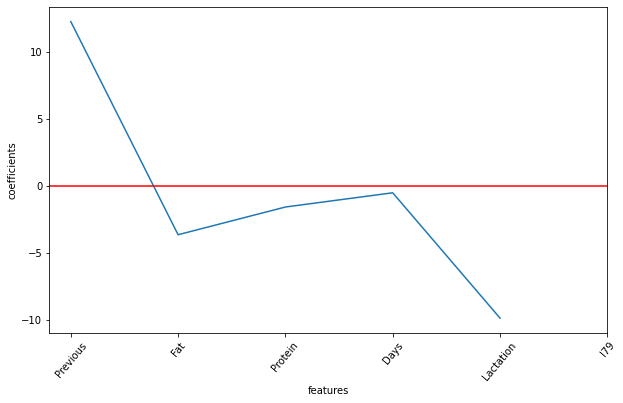

[ 58.79795096  47.56689554  62.02949104  65.04582914  73.68482401
  99.1919722   55.15147425  29.48232506  59.93388101  62.52024187
  76.85164381  64.30909995  44.99794225  79.58266344  65.23290056
  57.41920869  49.17324897  58.95914942  78.7200852   82.12874809
  70.6227922   55.21945428  34.37739452  79.21321064  44.55828898
  52.88075945  73.66574312  88.5556344  102.52012474  65.0767005
  67.04664047  64.24815017  61.67858777  85.48060747  62.05403011
  34.83813851  69.94459751  61.23982104  55.89929597  86.26932076
  37.37534966  41.78406515  76.08415553  82.97040219  83.58840756
 100.69564608  70.98892328  60.21452184  68.40164621  49.48677099]


In [88]:
tune_algorithm(lr,train_x,train_y,test_x,'lr')

### Mean RMSE of Feature selection(SelectKBest)+Multiple Linear Regression:9.909

### Best number of features k:5(preferably drop predictor variable Fat)


### Feature Selection for Linear Regression+PLS Regression using mutual info regression

Best RMSE: -9.909
Best Config: {'lr__n_components': 5, 'sel__k': 5}
Best estimator: Pipeline(steps=[('se',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('e', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('sel',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_regression at 0x00000222DAEC8280>)),
                ('lr', PLSRegression(n_components=5))])
>-11.116 with: {'lr__n_components': 1, 'sel__k': 1}
>-10.811 with: {'lr__n_components': 1, 'sel__k': 2}
>-10.400 with: {'lr__n_components': 1, 'sel__k': 3}
>-10.437 with: {'lr__n_components': 1, 'sel__k': 4}
>-10.585 with: {'lr__n_components': 1, 'sel__k': 5}
>-10.790 with: {'lr__n_components': 1, 'sel__k': 6}
>nan with: {'lr__n_components': 2, 'sel__k': 1}
>-10.448 with: {'lr__n_components': 2, 'sel__k': 2}
>-10.068 with: {'lr__n_components': 2, 'sel__k': 3}
>-10.136 wit

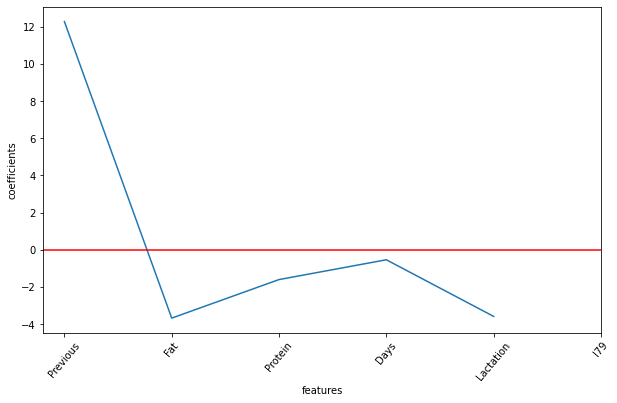

[[ 58.79795096]
 [ 47.56689554]
 [ 62.02949104]
 [ 65.04582914]
 [ 73.68482401]
 [ 99.1919722 ]
 [ 55.15147425]
 [ 29.48232506]
 [ 59.93388101]
 [ 62.52024187]
 [ 76.85164381]
 [ 64.30909995]
 [ 44.99794225]
 [ 79.58266344]
 [ 65.23290056]
 [ 57.41920869]
 [ 49.17324897]
 [ 58.95914942]
 [ 78.7200852 ]
 [ 82.12874809]
 [ 70.6227922 ]
 [ 55.21945428]
 [ 34.37739452]
 [ 79.21321064]
 [ 44.55828898]
 [ 52.88075945]
 [ 73.66574312]
 [ 88.5556344 ]
 [102.52012474]
 [ 65.0767005 ]
 [ 67.04664047]
 [ 64.24815017]
 [ 61.67858777]
 [ 85.48060747]
 [ 62.05403011]
 [ 34.83813851]
 [ 69.94459751]
 [ 61.23982104]
 [ 55.89929597]
 [ 86.26932076]
 [ 37.37534966]
 [ 41.78406515]
 [ 76.08415553]
 [ 82.97040219]
 [ 83.58840756]
 [100.69564608]
 [ 70.98892328]
 [ 60.21452184]
 [ 68.40164621]
 [ 49.48677099]]


In [89]:
pl = PLSRegression()
tune_algorithm(pl,train_x,train_y,test_x,'pls')

### Mean RMSE of Feature selection(SelectKBest)+Multiple Linear Regression:9.909

### Best number of features k:5(preferably drop predictor variable Fat)

### Best number of components for Partial Least Squares regression:5

### PLS regression is used to avoid multicollinearity


### Feature Selection for Linear Regression+Lasso Regression using mutual info regression

Best RMSE: -9.899
Best Config: {'lr__alpha': 0.1, 'sel__k': 5}
Best estimator: Pipeline(steps=[('se',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('e', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('sel',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_regression at 0x00000222DAEC8280>)),
                ('lr', Lasso(alpha=0.1))])
>-12.406 with: {'lr__alpha': 5, 'sel__k': 1}
>-12.293 with: {'lr__alpha': 5, 'sel__k': 2}
>-12.227 with: {'lr__alpha': 5, 'sel__k': 3}
>-12.225 with: {'lr__alpha': 5, 'sel__k': 4}
>-12.225 with: {'lr__alpha': 5, 'sel__k': 5}
>-12.225 with: {'lr__alpha': 5, 'sel__k': 6}
>-11.159 with: {'lr__alpha': 0.5, 'sel__k': 1}
>-10.482 with: {'lr__alpha': 0.5, 'sel__k': 2}
>-10.107 with: {'lr__alpha': 0.5, 'sel__k': 3}
>-10.059 with: {'lr__alpha': 0.5, 'sel__k': 4}
>-9.959 with: {'lr__alpha': 0.5, 'se

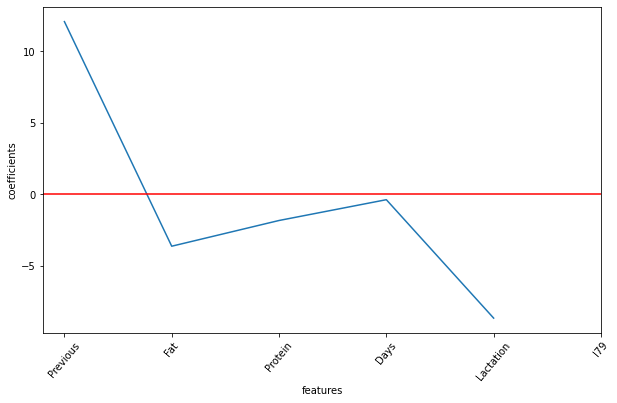

[ 59.0074582   47.50396454  62.35596539  65.54521377  73.72221892
  99.13504148  54.91331649  29.61123214  59.95460191  62.79224629
  76.76481983  64.49440575  44.79699424  79.60066169  65.19922881
  57.49021467  49.00520489  59.03370947  78.63363759  82.46361554
  69.80284571  55.42633718  34.87528342  79.11203845  44.49649496
  53.23122488  73.73233295  87.94992731 101.3957098   65.4789136
  67.06022084  63.9802558   61.90212216  85.4672968   62.16561267
  35.17239491  70.15974068  61.08236175  56.03312017  86.1346253
  37.94946401  42.00252821  75.28591969  83.35373967  83.96563385
  99.67561058  70.15283467  60.66504921  68.63082762  49.65607826]


In [90]:
model = Lasso()
tune_algorithm(model,train_x,train_y,test_x,'la')

### Mean RMSE of Feature selection(SelectKBest)+Multiple Linear Regression:9.899

### Best number of features k:5(preferably drop predictor variable Fat)

### Best alpha value for Lasso Regression:0.1

### Lasso regression tries to avoid multicollinearity by adjusting coefficients and moving coefficient of insignificant features closer to 0

### Here the coefficient of Lactation feature is close to 0

### So both the features Fat and Lactation are insignificant now.

### Now with the tuned hyperparameters let us try modeling from baseline model
### As per SelectKBest we can drop variable Fat

In [91]:
#seperating independent and dependent variables
x = encodeddata.drop(['CurrentMilk','Fat'], axis=1)
y = encodeddata['CurrentMilk']
x.shape, y.shape

((199, 5), (199,))

In [92]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=42)

In [93]:
# Creating instance of Linear Regresssion
lr = LR()

In [94]:
train_x

,Previous,Protein,Days,Lactation,I79
56,51,3.6,261,4.0,1
5,93,3.0,45,3.0,0
122,57,2.8,213,1.0,1
113,47,3.6,200,2.0,1
93,62,3.0,172,2.0,1
...,...,...,...,...,...
106,60,3.6,183,2.0,1
14,81,2.8,59,4.0,0
92,53,3.3,169,4.0,1
179,64,3.4,138,2.0,1


In [95]:
kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
sca_ix = [0,1,2,3]
cat_ix = [4]
# define the selective transforms
lr = LR()
t = [('e', StandardScaler(), sca_ix)]
selective = ColumnTransformer(transformers=t, remainder='passthrough')
pipeline = Pipeline(steps=[('se',selective), ('lr', lr)])
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, train_x, train_y, scoring='neg_root_mean_squared_error', cv=kf)
scores.mean()

-9.909327661550869

#### Basic linear regression model  after feature selection gives an average RMSE of 9.09

In [96]:
kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
model = PLSRegression(n_components=5)
sca_ix = [0,1,2,3]
cat_ix = [4]
# define the selective transforms
t = [('e', StandardScaler(), sca_ix)]
selective = ColumnTransformer(transformers=t, remainder='passthrough')
pipeline = Pipeline(steps=[('se',selective),('la', model)])
pipeline.fit(train_x,train_y)
testp=pipeline.predict(test_x)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, train_x, train_y, scoring='neg_root_mean_squared_error', cv=kf)
testp=testp.reshape(50,)
scores.mean()

-9.909327661550869

#### PLS regression model  after feature selection gives an average RMSE of 9.09

In [97]:
kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
model = Lasso(alpha=0.1)
sca_ix = [0,1,2,3]
cat_ix = [4]
# define the selective transforms
t = [('e', StandardScaler(), sca_ix)]
selective = ColumnTransformer(transformers=t, remainder='passthrough')
pipeline = Pipeline(steps=[('se',selective),('la', model)])
pipeline.fit(train_x,train_y)
testp=pipeline.predict(test_x)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, train_x, train_y, scoring='r2', cv=kf)
coeff=pipeline.named_steps['la'].coef_
print("R Squared:",scores.mean())
scores = cross_val_score(pipeline, train_x, train_y, scoring='neg_root_mean_squared_error', cv=kf)
print("Mean RMSE:",-(scores.mean()))

R Squared: 0.6063062159549273
Mean RMSE: 9.899241691764129


In [99]:
import sklearn
yp=pipeline.predict(train_x)
sklearn.metrics.r2_score(train_y, yp)

0.7183384162795091

#### Lasso regression model  after feature selection gives an average RMSE of 9.89

## Checking assumptions of Linear Model

#### Interpreting coefficients

In [ ]:
plt.figure(figsize=(5, 3), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = coeff
plt.bar( x, y )
plt.xlabel('Variables')
plt.ylabel('Coefficients')
plt.title('Coefficient plot')

### The plot shows that the most significant feature affecting current milk production is previous milk production

In [ ]:
# Arranging and calculating the Residuals
residuals = pd.DataFrame({
    'fitted values' : test_y,
    'predicted values' : testp,
})

residuals['residuals'] = residuals['fitted values'] - residuals['predicted values']
residuals

#### Plotting residual curve (Is there constant Variance OR Homoscedastic?)

In [ ]:
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,50)
k = [0 for i in range(0,50)]
plt.scatter( f, residuals.residuals[:], label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.ylim(-4000, 4000)
plt.legend()

### The Residual plot clearly looks Homoscedastic, i.e. the the variance of the error across the dataset is nearly constant.

### Checking Distribution of Residuals

In [ ]:
# Histogram for distribution
plt.figure(figsize=(5, 4), dpi=120, facecolor='w', edgecolor='b')
plt.hist(residuals.residuals, bins = 15)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
plt.show()

### The Residual distribution is normal with some outliers

### QQ-Plot (Is the data Normally Distributed?)

In [ ]:
# importing the QQ-plot from the from the statsmodels
from statsmodels.graphics.gofplots import qqplot

## Plotting the QQ plot
fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
qqplot(residuals.residuals, line = 's' , ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')
plt.show()

#### The QQ-plot clearly verifies our findings from the the histogram of the residuals, the data is mostly normal in nature, but there sre some outliers on both ends of the Residues.

### Thus we are getting the least RMSE when using the Lasso regression which is used to avoid multicollinearity.This is justified also as we saw that the model has inherent multicolliearity

### The techniques used are feature selection using SelectKBest with mutual info regression and then Lasso Regression/Regularized multiple linear regression

### a) Do you think a linear model is appropriate to describe the association between response and explanatory? If yes, is the association/correlation between response and each explanatory variable are reasonably strong or quite weak? By plotting each independent variable vs. dependent variable suggest an increasing or decreasing relationship between them?

#### Done via plots.Yes.Linear model is appropriate.Association between independant and dependant variables plotted.Most of assumptions were satisfied.Exception was multicollinearity which we resolved by regularizing using Lasso Regression

### b) Describe all the possible relationships (independent vs. dependent). Which relationship seems most appropriate for a linear model?

#### As per plots,the most appropriate is previous milk production versus current milk production which should be directly proportional

### Regardless of your conclusions in questions b, let’s explore briefly the regression of response variable on explanatory variables.

### a) Build a regression model using response and explanatory variables. How many significant variables were used to fit the reduced model? Insert the line into the corresponding scatterplot and paste it into your report. Does the line provide a good fit?
#### 5 significant variables excluding Fat were used and Lasso regularization adjusted to remove Lactation.So model has 4 significant variables Previous,Protein,Days and I79


### b) What percent of the variation in current month milk production is explained by influencing variables?

#### 60.6% variation in current month milk production was explained by the significant variables

### c) Obtain the plot of standardized residuals versus standardized predicted values for the regression model and describe the pattern of the residuals. Comment on the assumption of constant variance.
#### Done.Constant variance observed

### d) Obtain the normality plot of standardized residuals and comment on the assumption of normality.
#### Done.Normal distribution with outliers


### a) Consider you as a Data analyst in The dairy Herd Improvement Cooperative (DHI), suggest a most important factor which will contribute in the production of Current month milk production in pounds (explain it with the direction in which the rate changes)

#### The most important factor which will contribute in production of Current month milk production is previous month milk production.
#### They are directly proportional/have a positive linear relationship,So especially cows giving more milk this month will have more probability to give more milk next month.So take appropriate measures